# БЛОК 1

## 1) Развернуть standalone cluster Spark: master + 2 workers. Приложить скрипт и/или алгоритм + скрин webui.

In [ ]:
# запускаем master
./sbin/start-master.sh

# Проверяем по ссылке http://localhost:8080/ 

# Создаем файл spark-env.sh, для этого делаем копию spark-env.sh.template
cp  spark-env.sh.template  spark-env.sh

# Делаем файл исполняемым
chmod u+x spark-env.sh

# В файле spark-env.sh прописываем количество работников, количество ядер на работника и память

SPARK_WORKER_CORES=2 
SPARK_WORKER_INSTANCES=2 
SPARK_WORKER_MEMORY=4g

#Запускаем workers
./sbin/start-worker.sh spark://DESKTOP-1G6HT9G.localdomain:7077 

#Все остановить:
#./sbin/stop-all.sh


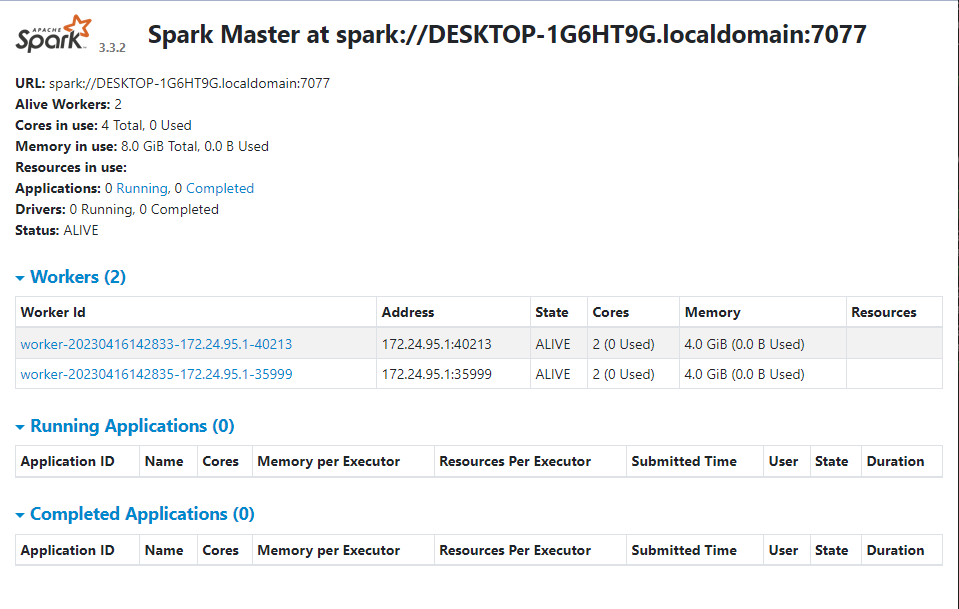

## 2) Подключиться к кластеру с помощью Jupyter. Приложить скрипт и/или алгоритм + скрин рабочей сессии из инструмента

In [1]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark.init()

In [3]:
sc.stop()

In [4]:
from pyspark import SparkContext
sc = SparkContext(master = "spark://DESKTOP-1G6HT9G.localdomain:7077").getOrCreate()

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("spark://DESKTOP-1G6HT9G.localdomain:7077").getOrCreate()

In [6]:
spark

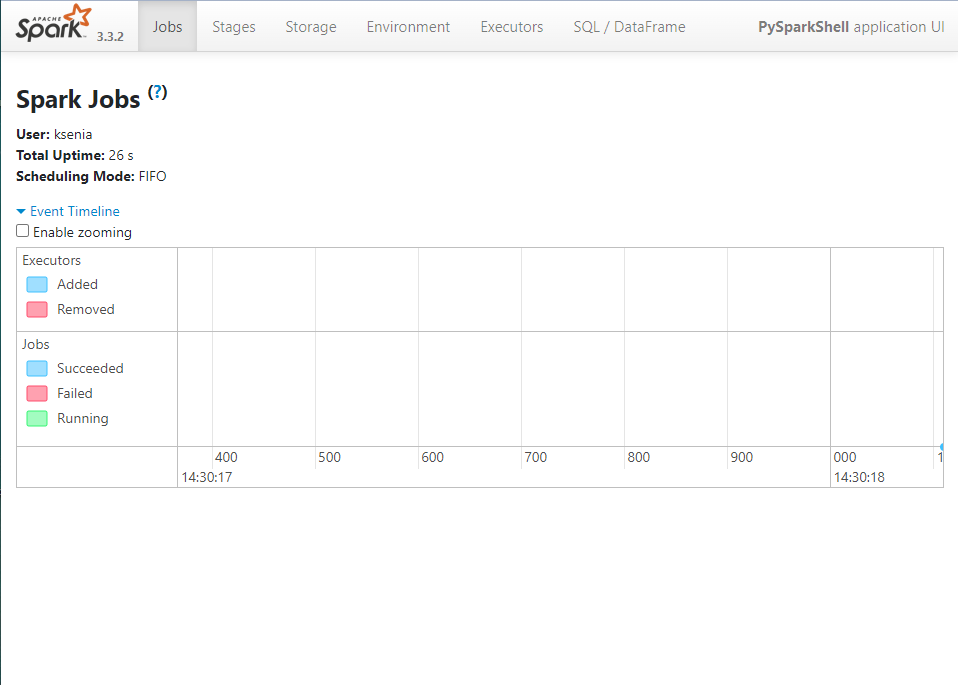

# БЛОК 2

## 1) Преобразовать данные исходного датасета в parquet объединяя все таблицы. Оценить разницу в скорости чтения / занимаемом объеме. Сделать выводы. 

**Объединим файлы в один csv и parquet**

In [ ]:
import pandas as pd
import glob
files = glob.glob(os.path.join('/home/ksenia/data', '*.csv'))

combined = pd.DataFrame()

for file in files:
    data = pd.read_csv(file)
    combined = pd.concat([combined, data])
    
combined.to_csv("/home/ksenia/books.csv", index=False)

In [13]:
combined.to_parquet('booksdata.parquet', index=False)

**Сравним объемы файлов**

In [2]:
import os.path
def convert(size):
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0
        
csv_size = os.path.getsize('/home/ksenia/books.csv')
csv_prep = convert(csv_size)
parquet_size = os.path.getsize('/home/ksenia/booksdata.parquet')
parquet_prep = convert(parquet_size)
print('Размер файла в csv:', csv_prep)
print('Размер файла в parquet', parquet_prep)

Размер файла в csv: 1.1 GB
Размер файла в parquet 677.2 MB


**Сравним скорость чтения**

In [4]:
from datetime import datetime
import pandas as pd
start_time = datetime.now()
booksincsv = pd.read_csv('/home/ksenia/books.csv')
end_time = datetime.now()
print('Длительность чтения csv: {}'.format(end_time - start_time))

/tmp/ipykernel_29365/927338716.py:4: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  booksincsv = pd.read_csv('/home/ksenia/books.csv')


Длительность чтения csv: 0:00:31.458610


In [3]:
from datetime import datetime
import pandas as pd
start_time = datetime.now()
booksinparquet = pd.read_parquet('/home/ksenia/booksdata.parquet')
end_time = datetime.now()
print('Длительность чтения parquet: {}'.format(end_time - start_time))

Длительность чтения parquet: 0:00:27.216102


**Вывод: формат parquet занимает меньше места и читается быстрее.**

## 2) Используя весь набор данных с помощью Spark вывести...

In [ ]:
df = spark.read.options(header=True).csv("/home/ksenia/books.csv")

In [13]:
df.printSchema()

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- RatingDist1: string (nullable = true)
 |-- pagesNumber3: string (nullable = true)
 |-- RatingDist4: string (nullable = true)
 |-- RatingDistTotal: string (nullable = true)
 |-- PublishMonth: string (nullable = true)
 |-- PublishDay: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- CountsOfReview: string (nullable = true)
 |-- PublishYear: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Authors: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- RatingDist2: string (nullable = true)
 |-- RatingDist5: string (nullable = true)
 |-- ISBN: string (nullable = true)
 |-- RatingDist3: string (nullable = true)
 |-- PagesNumber18: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Count of text reviews: string (nullable = true)



## a) Топ-10 книг с наибольшим числом ревью

In [30]:
df = df.withColumn('CountsOfReview',df.CountsOfReview.cast('int'))

In [32]:
df.orderBy(df['CountsOfReview'].desc()).select(df['Name']).show(10) 

+--------------------+
|                Name|
+--------------------+
|The Hunger Games ...|
|Twilight (Twiligh...|
|      The Book Thief|
|            The Help|
|Harry Potter and ...|
|The Giver (The Gi...|
| Water for Elephants|
|The Girl with the...|
|Harry Potter and ...|
|The Lightning Thi...|
+--------------------+
only showing top 10 rows



## b) Топ-10 издателей с наибольшим средним числом страниц в книгах

In [33]:
df = df.withColumn('pagesNumber3',df.pagesNumber3.cast('int'))

In [44]:
df_new = df.groupby("Publisher").avg("pagesNumber3")

In [46]:
df_new.orderBy(df_new['avg(pagesNumber3)'].desc()).show(10) 

+--------------------+------------------+
|           Publisher| avg(pagesNumber3)|
+--------------------+------------------+
|Crafty Secrets Pu...|1505991.6666666667|
|Department of Rus...| 751434.3333333334|
|Encyclopedia Brit...|           32642.0|
|Progressive Manag...|18973.270833333332|
|Still Waters Revi...|           12188.0|
|P. Shalom Publica...|            8539.0|
|     Edition Synapse|            7060.0|
|Hendrickson Publi...|            6448.0|
|Apple Pie Publish...|            6000.0|
|   Hendrickson Publ.|            5808.0|
+--------------------+------------------+
only showing top 10 rows



## c) Десять наиболее активных по числу изданных книг лет

In [51]:
df = df.withColumn('PublishYear',df.PublishYear.cast('int'))

In [52]:
df_PublishYear = df.groupby("PublishYear").count()

In [53]:
df_PublishYear.orderBy(df_PublishYear['count'].desc()).show(10) 

+-----------+------+
|PublishYear| count|
+-----------+------+
|       2007|129443|
|       2006|122305|
|       2005|117570|
|       2004|105668|
|       2003|104286|
|       2002| 95485|
|       2001| 88182|
|       2000| 87245|
|       2008| 80224|
|       1999| 80099|
+-----------+------+
only showing top 10 rows



## d) Топ-10 книг имеющих наибольший разброс в оценках среди книг имеющих больше 500 оценок

In [17]:
from statistics import stdev
from pyspark.sql.functions import udf, concat_ws, expr
from pyspark.sql.types import FloatType

def find_stdev(line):
    return stdev([float(x[2:].strip()) for x in line.split(",")])

find_stdev_udf = udf(find_stdev, FloatType())

In [18]:
df_std = df.withColumn('StdDev', find_stdev_udf(concat_ws(",", df.RatingDist1, df.RatingDist2,\
                                                       df.RatingDist3, df.RatingDist4, df.RatingDist5)))

In [19]:
df_std = df_std.withColumn('Total', expr("substring(RatingDistTotal, 7, length(RatingDistTotal)-7)").cast('Integer'))

In [21]:
df_std.select('Name', 'StdDev', 'Total').where('Total > 500' ).orderBy(df_std['StdDev'].desc()).show(10)

+--------------------+---------+------+
|                Name|   StdDev| Total|
+--------------------+---------+------+
|Ο Χάρι Πότερ και ...|1884481.0|709468|
|Harry Potter og D...|1857551.5|699559|
|Harry Potter e a ...|1856879.5|699315|
|Harry Potter and ...|1850987.2|697097|
|Harry Potter och ...|1833126.8|690522|
|Harry Potter och ...|1824451.8|687169|
|Harry Potter e a ...|1822858.0|686591|
|Harry Potter and ...|1815587.4|683920|
|Harry Potter i Ka...|1814183.4|683396|
|Harri Potter maen...|1811594.9|682464|
+--------------------+---------+------+
only showing top 10 rows



## e) Любой интересный инсайт из данных: как менялось количество разных языков, на которых печатали книги за последние 20 лет

In [30]:
df = df.withColumn('PublishYear', df.PublishYear.cast('int'))

In [33]:
from pyspark.sql.functions import countDistinct
df_PublishYear_Lang = df.select('PublishYear', 'Language').where('PublishYear > 2002').groupby("PublishYear").agg(countDistinct('Language'))

In [35]:
df_PublishYear_Lang.orderBy('PublishYear').show()

+-----------+---------------+
|PublishYear|count(Language)|
+-----------+---------------+
|       2003|             49|
|       2004|             42|
|       2005|             48|
|       2006|             48|
|       2007|             50|
|       2008|             41|
|       2009|             25|
|       2010|             25|
|       2011|             22|
|       2012|             18|
|       2013|             15|
|       2014|             17|
|       2015|             12|
|       2016|              9|
|       2017|             11|
|       2018|             10|
|       2019|              6|
|       2020|              4|
|       2021|              1|
|       2022|              0|
+-----------+---------------+
only showing top 20 rows



Как ни странно, но количество уникальных языков, на которых печатались книги, постепенно уменьшалось. Возможно, это связано с качеством данных, недостатком информации за последние годы.

# БЛОК 3

## Расчет среднего рейтинга книги на Spark Streaming.

In [37]:
from pyspark.sql.types import *
from pyspark.sql.functions import *

schema = StructType([StructField("ID", IntegerType(), True), StructField("Name", StringType(), True),
                     StructField("Rating", StringType(), True)])

Читаем данные и смотрим, какие значения принимает Rating

In [41]:
streaming = spark.readStream.option("quote", "\"").option("escape", "\"").schema(schema).csv('./data_user/')
rating = streaming.groupBy('Rating').count()
active_query = rating.writeStream.format('console').outputMode('complete').start()

23/06/17 19:39:10 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-fb0869df-dbe7-45b2-a088-e33c21c7398b. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/06/17 19:39:10 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


-------------------------------------------
Batch: 0
-------------------------------------------
+--------------------+------+
|              Rating| count|
+--------------------+------+
|     did not like it|  7811|
|              Rating|     7|
|     really liked it|132808|
|            liked it| 96047|
|           it was ok| 28811|
|      it was amazing| 92354|
|This user doesn't...|  4765|
+--------------------+------+



In [42]:
streaming.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Rating: string (nullable = true)



Функция для преобразования текстовых отзывов в числа для дальнейшего расчета.

In [43]:
def text_to_number(k):
    if k == 'it was amazing':
        return 5
    elif k == 'really liked it':
        return 4
    elif k == 'liked it':
        return 3
    elif k == 'it was ok':
        return 2
    elif k == 'did not like it':
        return 1
    else:
        return

In [46]:
def foreach_batch_function(df, epoch_id):
    text_to_number_UDF = udf(text_to_number, IntegerType())
    df = df.withColumn('Prep_rating', text_to_number_UDF('Rating'))    
    windowed = df.groupBy("Name").agg(avg("Prep_rating").alias('avg_rating'))
    windowed.write.parquet('./data_user/parquet')
    
streaming.writeStream.foreachBatch(foreach_batch_function).start() 

23/06/17 19:56:42 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-815f4e51-efc5-45b5-b972-1ffb4a43b001. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
23/06/17 19:56:42 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


In [47]:
spark.streams.active

In [48]:
spark.streams.active[0].stop()

Проверка:

In [50]:
df_parquet = spark.read.parquet('./data_user/parquet', header=True)
df_parquet.show()

+--------------------+------------------+
|                Name|        avg_rating|
+--------------------+------------------+
|A Feast for Crows...|3.6733333333333333|
|         Fingersmith|3.9166666666666665|
|The Maze Runner (...|3.0930232558139537|
|     The Nickel Boys|              4.35|
|Barbarian Days: A...| 4.266666666666667|
|Chaos Monkeys: Ob...|3.3636363636363638|
|Assholes Finish F...|              2.25|
|God Save the Fan:...|               3.0|
|         Small World|               5.0|
|The Three Golden ...|               4.0|
|An American Marriage|3.9523809523809526|
|   The Kitchen House|3.8292682926829267|
|This is Where I L...|  3.63768115942029|
|Insurgent (Diverg...| 3.397727272727273|
|The Audacity of H...|             3.725|
|             Baggage|               4.0|
| Blue Hat, Green Hat|               4.5|
|    The Interestings| 3.574712643678161|
|     Just So Stories|            3.8125|
|101 Designer One-...|               3.5|
+--------------------+------------